# Setup

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding,Bidirectional,Dropout,BatchNormalization,GlobalMaxPool1D,Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns; sns.set()
import string
import re
from nltk.tokenize import TweetTokenizer

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importação do Dataset

In [4]:
train_df = pd.read_csv('/content/drive/My Drive/Deep Learning 2020/deep_learning_2020_lista_3/train.csv')
test_df = pd.read_csv('/content/drive/My Drive/Deep Learning 2020/deep_learning_2020_lista_3/test.csv')

# Preprocessamento

In [5]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
(train_df.isnull()==True).sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [7]:
train_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [8]:
train_df[train_df['keyword'].isnull()==False]

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...,...,...
7578,10830,wrecked,NaN,@jt_ruff23 @cameronhacker and I wrecked you both,0
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0


In [9]:
ids_with_target_error = [328,443,513,2619,3640,3900,4342,5781,6552,6554,6570,6701,6702,6729,6861,7226]
train_df[train_df['id'].isin(ids_with_target_error)]

,id,keyword,location,text,target
229,328,annihilated,NaN,Ready to get annihilated for the BUCS game,1
301,443,apocalypse,NaN,Short Reading\n\nApocalypse 21:1023 \n\nIn the...,1
356,513,army,Studio,But if you build an army of 100 dogs and their...,1
1822,2619,crashed,NaN,My iPod crashed..... \n#WeLoveYouLouis \n#MTVH...,1
2536,3640,desolation,"Quilmes , Arg",This desperation dislocation\nSeparation conde...,1
2715,3900,devastated,PG Chillin!,Man Currensy really be talkin that talk... I'd...,1
3024,4342,dust%20storm,chicago,Going to a fest? Bring swimming goggles for th...,1
4068,5781,forest%20fires,NaN,Campsite recommendations \nToilets /shower \nP...,1
4609,6552,injury,Saint Paul,My prediction for the Vikings game this Sunday...,1
4611,6554,injury,NaN,Dante Exum's knee injury could stem Jazz's hop...,1


In [10]:
train_df.loc[train_df['id'].isin(ids_with_target_error),'target'] = 0
train_df[train_df['id'].isin(ids_with_target_error)]

,id,keyword,location,text,target
229,328,annihilated,NaN,Ready to get annihilated for the BUCS game,0
301,443,apocalypse,NaN,Short Reading\n\nApocalypse 21:1023 \n\nIn the...,0
356,513,army,Studio,But if you build an army of 100 dogs and their...,0
1822,2619,crashed,NaN,My iPod crashed..... \n#WeLoveYouLouis \n#MTVH...,0
2536,3640,desolation,"Quilmes , Arg",This desperation dislocation\nSeparation conde...,0
2715,3900,devastated,PG Chillin!,Man Currensy really be talkin that talk... I'd...,0
3024,4342,dust%20storm,chicago,Going to a fest? Bring swimming goggles for th...,0
4068,5781,forest%20fires,NaN,Campsite recommendations \nToilets /shower \nP...,0
4609,6552,injury,Saint Paul,My prediction for the Vikings game this Sunday...,0
4611,6554,injury,NaN,Dante Exum's knee injury could stem Jazz's hop...,0


In [11]:
train_df.loc[train_df['keyword'].notnull(), 'text'] = train_df['keyword'] + ' ' + train_df['text']

In [12]:
def convert_abbrev_in_text(text):
    t = []
    words = text.split()
    t = [abbreviations[w.lower()] if w.lower() in abbreviations.keys() else w for w in words]
    return ' '.join(t)  

In [13]:
tknzr = TweetTokenizer(strip_handles=True)
stop_words = set(stopwords.words('english'))
corpus = []

def clean_data(text):
    # special characters
    text = re.sub(r"\x89Û_", "", text)
    text = re.sub(r"\x89ÛÒ", "", text)
    text = re.sub(r"\x89ÛÓ", "", text)
    text = re.sub(r"\x89ÛÏWhen", "When", text)
    text = re.sub(r"\x89ÛÏ", "", text)
    text = re.sub(r"China\x89Ûªs", "China's", text)
    text = re.sub(r"let\x89Ûªs", "let's", text)
    text = re.sub(r"\x89Û÷", "", text)
    text = re.sub(r"\x89Ûª", "", text)
    text = re.sub(r"\x89Û\x9d", "", text)
    text = re.sub(r"å_", "", text)
    text = re.sub(r"\x89Û¢", "", text)
    text = re.sub(r"\x89Û¢åÊ", "", text)
    text = re.sub(r"fromåÊwounds", "from wounds", text)
    text = re.sub(r"åÊ", "", text)
    text = re.sub(r"åÈ", "", text)
    text = re.sub(r"JapÌ_n", "Japan", text)    
    text = re.sub(r"Ì©", "e", text)
    text = re.sub(r"å¨", "", text)
    text = re.sub(r"SuruÌ¤", "Suruc", text)
    text = re.sub(r"åÇ", "", text)
    text = re.sub(r"å£3million", "3 million", text)
    text = re.sub(r"åÀ", "", text)
    
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # remove numbers
    text = re.sub(r'[0-9]', '', text)
    
    # remove punctuation and special chars (keep '!')
    for p in string.punctuation.replace('!', ''):
        text = text.replace(p, '')
        
    # remove urls
    text = re.sub(r'http\S+', '', text)
    
    # tokenize
    text = tknzr.tokenize(text)
    
    # remove stopwords
    text = [w.lower() for w in text if not w in stop_words]
    corpus.append(text)
    
    # join back
    text = ' '.join(text)
    
    return text


In [14]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
     "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [15]:
train_df['text'] = train_df['text'].apply(clean_data)
train_df['text'] = train_df['text'].apply(convert_abbrev_in_text)

In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['text'])

sequences = tokenizer.texts_to_sequences(train_df['text'])
pad = pad_sequences(sequences, maxlen=120, padding='post', truncating='post')

# Treinamento da LSTM

In [17]:
partition = int(len(train_df)*0.8);
y_train = train_df['target'].iloc[0:partition]
y_test = train_df['target'].iloc[partition:len(train_df)]
X_train = pad[0:partition]
X_test = pad[partition:len(train_df)]

vocab_size=len(tokenizer.word_index)+1

In [18]:
model = Sequential()
model.add(Embedding(vocab_size, 32, input_length=pad.shape[1]))
model.add(Bidirectional(LSTM(32,return_sequences=True)))
model.add(Dropout(0.7))

model.add(Bidirectional(LSTM(32,return_sequences=True)))
model.add(Dropout(0.7))

model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.7))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 32)           539616    
_________________________________________________________________
bidirectional (Bidirectional (None, 120, 64)           16640     
_________________________________________________________________
dropout (Dropout)            (None, 120, 64)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 120, 64)           24832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 120, 64)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                24832     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0

In [19]:
history = model.fit(X_train, y_train, 
                    epochs=10, 
                    validation_data=(X_test, y_test)
                    )

Epoch 1/10
191/191 [==============================] - 51s 267ms/step - loss: 0.6463 - accuracy: 0.6250 - val_loss: 0.5252 - val_accuracy: 0.7597
Epoch 2/10
191/191 [==============================] - 48s 252ms/step - loss: 0.3982 - accuracy: 0.8419 - val_loss: 0.5046 - val_accuracy: 0.7676
Epoch 3/10
191/191 [==============================] - 47s 248ms/step - loss: 0.2381 - accuracy: 0.9232 - val_loss: 0.5535 - val_accuracy: 0.7597
Epoch 4/10
191/191 [==============================] - 47s 248ms/step - loss: 0.1544 - accuracy: 0.9530 - val_loss: 0.7386 - val_accuracy: 0.7472
Epoch 5/10
191/191 [==============================] - 48s 249ms/step - loss: 0.1180 - accuracy: 0.9657 - val_loss: 0.8681 - val_accuracy: 0.7242
Epoch 6/10
191/191 [==============================] - 48s 252ms/step - loss: 0.0972 - accuracy: 0.9724 - val_loss: 0.8313 - val_accuracy: 0.7223
Epoch 7/10
191/191 [==============================] - 48s 253ms/step - loss: 0.0813 - accuracy: 0.9739 - val_loss: 0.9951 - val_ac

# Avaliação da performance da LSTM

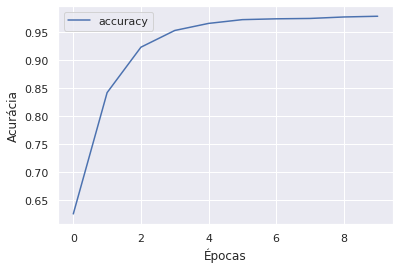

In [20]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

In [21]:
test_val_df = train_df.sample(frac=0.25)

In [22]:
test_val_df.loc[test_val_df['keyword'].notnull(), 'text'] = test_val_df['keyword'] + ' ' + test_val_df['text']
test_val_df['text'] = test_val_df['text'].apply(clean_data)

t_sequences = tokenizer.texts_to_sequences(test_val_df['text'])
t_pad = pad_sequences(t_sequences, maxlen=120, padding='post', truncating='post')

In [23]:
predictions = model.predict(t_pad)

In [24]:
predictions

array([[2.8028699e-05],
       [7.5526434e-05],
       [9.9995124e-01],
       ...,
       [9.9997616e-01],
       [7.4304538e-05],
       [9.9997842e-01]], dtype=float32)

In [25]:
predictions_ = []
for i in range(len(predictions)):
  predictions_.append(np.round(predictions[i]))

In [26]:
mat = tf.math.confusion_matrix(test_val_df['target'], predictions_)
mat

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1019,   89],
       [  72,  723]], dtype=int32)>

Text(66.5, 0.5, 'predicted label')

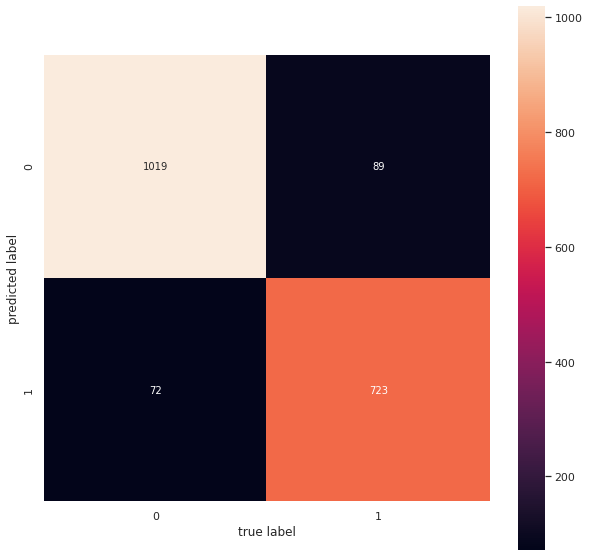

In [27]:
plt.figure(figsize=(10,10))
ax= plt.subplot(111)
ax= sns.heatmap(mat, square=True, annot=True, fmt='g', cbar=True, ax=ax)
plt.xlabel('true label')
plt.ylabel('predicted label')

# Fazendo previsões de novos dados

In [28]:
test_df.loc[test_df['keyword'].notnull(), 'text'] = test_df['keyword'] + ' ' + test_df['text']
test_df['text'] = test_df['text'].apply(clean_data)

t_sequences = tokenizer.texts_to_sequences(test_df['text'])
t_pad = pad_sequences(t_sequences, maxlen=120, padding='post', truncating='post')

In [29]:
predictions = model.predict(t_pad)

In [30]:
predictions_ = []
for i in range(len(predictions)):
  predictions_.append(np.round(predictions[i]))

In [31]:
test_df['predictions'] = predictions_